In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53523 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:53526" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:53545, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:53548, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:53551, threads: 2>})

In [4]:
model_data = pd.read_pickle('DFs/model_data.pkl')

In [5]:
def cross_val_time(model, algo,  X, y, split=5):
    count=1
    tscv = TimeSeriesSplit(n_splits=split)
    scoretemp = {algo+'_MAE':[], algo+'_MSE':[], algo+'_MPE':[]}
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(train_index[0], train_index[-1], test_index[0], test_index[-1])
        with joblib.parallel_backend('dask'):
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #scoretemp[algo + '_R2'].append(r2_score(y_test, y_pred))
        scoretemp[algo + '_MAE'].append(mean_absolute_error(y_test, y_pred))
        scoretemp[algo + '_MSE'].append(mean_squared_error(y_test, y_pred))
        scoretemp[algo + '_MPE'].append(mean_absolute_percentage_error(y_test, y_pred))
        for i in scoretemp.keys():
            print(i + ': '+ str(scoretemp[i][count-1]))
        count+=1
    scoretemp = pd.DataFrame(scoretemp)
    return scoretemp

In [6]:
def Xy_prep(df, target, a=1, b=75):
    df_1 = df.loc[df['PID'].between(a, b)]
    drop_cols = ['PID', 'SID', 'target_5', 'target_10', 'target_20', 'X', 'Y','Z', 'segment']
    df_1i = df_1.set_index('millisecond')
    participants = b-a+1
    cut_rows = int(target[-2:])*participants*10
    X = df_1i.drop(columns=drop_cols).to_numpy()[:len(df)-cut_rows]
    y = df_1i[target].to_numpy()[:len(df)-cut_rows]
    cols = df_1i.drop(columns=drop_cols).columns
    participants = b-a+1
    
    return X, y, cols, participants, cut_rows

In [7]:
X, y, cols, participants, cut_rows = Xy_prep(model_data, 'target_20', 15, 20)
#seperating out pieces based on how many paricipants used cutting point at end
end_sil_train = int(( (len(X) - cut_rows) / 2 ) * (2/3))
print(end_sil_train)
end_sil_test = int(( len(X) - cut_rows) / 2)
print(end_sil_test)
start_music_test = int(end_sil_test + end_sil_test * (2/3))
print(start_music_test)
print(len(X))
X_train_sil = X[:end_sil_train, :]
X_test_sil = X[end_sil_train:end_sil_test, :]
y_train_sil = y[:end_sil_train]
y_test_sil = y[end_sil_train:end_sil_test]


X_train_music = X[end_sil_test:start_music_test, :]
X_test_music = X[start_music_test:, :]
y_train_music = y[end_sil_test:start_music_test]
y_test_music = y[start_music_test:]

3162
4743
7905
10686


In [8]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_sil, y_train_sil)
dummy.score(X_test_sil, y_test_sil)

-0.14520919603796867

In [9]:
rf1_sil = RandomForestRegressor()
with joblib.parallel_backend('dask'):
    rf1_sil.fit(X_train_sil, y_train_sil)
rf1_sil.score(X_test_sil, y_test_sil)

0.4188028772817658

In [10]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_music, y_train_music)
dummy.score(X_test_music, y_test_music)

-0.8856330924854565

In [11]:
rf1_music = RandomForestRegressor(n_estimators=150)
with joblib.parallel_backend('dask'):
    rf1_music.fit(X_train_music, y_train_music)
rf1_music.score(X_test_music, y_test_music)

-1.0256860767908806

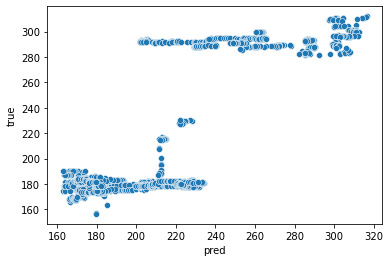

In [12]:
y_pred_sil = rf1_sil.predict(X_test_sil)
sns.scatterplot(y=y_pred_sil, x=y_test_sil)
plt.ylabel('true')
plt.xlabel('pred')
plt.show()

In [13]:
plot_sil = pd.DataFrame(y_pred_sil, columns=['pred'])
plot_sil.insert(0, value=y_test_sil, column='true')
plot_sil

,true,pred
0,214.965382,215.133501
1,166.616640,166.189865
2,315.166921,310.565197
3,168.914984,169.180681
4,181.066073,181.627281
...,...,...
1576,231.445120,181.750981
1577,248.735155,291.063570
1578,222.381869,179.673208
1579,179.931467,181.684654


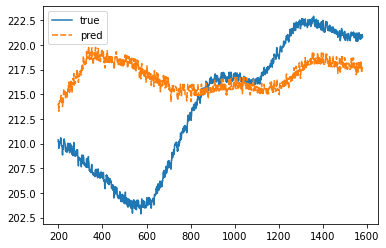

In [14]:
sns.lineplot(data=plot_sil.rolling(200).mean())
plt.show()

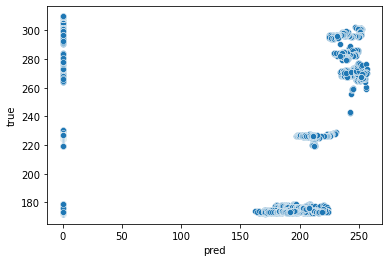

In [15]:
y_pred_music = rf1_music.predict(X_test_music)
sns.scatterplot(y=y_pred_music, x=y_test_music)
plt.ylabel('true')
plt.xlabel('pred')
plt.show()

In [16]:
plot_mus = pd.DataFrame(y_pred_music, columns=['pred'])
plot_mus.insert(0, value=y_test_music, column='true')
plot_mus

,true,pred
0,179.958018,177.918940
1,170.806600,172.206754
2,242.401164,242.453218
3,172.683465,172.550466
4,256.369114,259.362832
...,...,...
2776,0.000000,178.907687
2777,0.000000,309.804861
2778,0.000000,227.259027
2779,0.000000,173.236438


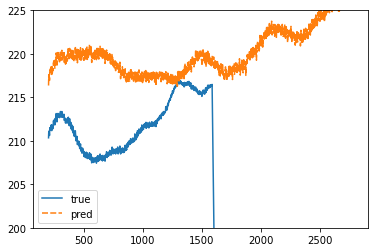

In [17]:
sns.lineplot(data=plot_mus.rolling(200).mean())
plt.ylim(200, 225)
plt.show()